# Fonds Macro Global - Analyse du Risque de Corrélation Internationale


## 2.1 Caractérisation de la variable dépendante


**Objectif :** Analyser les corrélations mobiles entre le S&P 500 et 5 indices internationaux


**Indices sélectionnés :**


- **Marchés développés :** DAX 40 (Allemagne), Nikkei 225 (Japon), HSI (Hong Kong/Chine)


- **Marchés émergents :** Bovespa (Brésil), Nifty 50 (Inde)


**Période d'analyse :** 2010 à aujourd'hui (données quotidiennes)


**Fenêtre de corrélation :** 126 jours (6 mois)

In [206]:
# Importation des bibliothèques nécessaires
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("Bibliothèques importées avec succès!")
print(f"Date d'analyse : {datetime.now().strftime('%Y-%m-%d')}")

Bibliothèques importées avec succès!
Date d'analyse : 2025-11-10


In [207]:
# Définition des tickers Yahoo Finance pour les indices
tickers = {
    'S&P 500': '^GSPC',       # Référence américaine
    'DAX 40': '^GDAXI',       # Allemagne (marché développé)
    'Nikkei 225': '^N225',    # Japon (marché développé)
    'Bovespa': '^BVSP',       # Brésil (marché émergent)
    'Nifty 50': '^NSEI',      # Inde (marché émergent)
    'HSI': '^HSI'             # Hong Kong/Chine (marché asiatique)
}

# Période d'analyse : 2010 à aujourd'hui
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print("Tickers définis :")
for nom, ticker in tickers.items():
    print(f"  {nom}: {ticker}")
print(f"\nPériode d'analyse : {start_date} à {end_date}")

Tickers définis :
  S&P 500: ^GSPC
  DAX 40: ^GDAXI
  Nikkei 225: ^N225
  Bovespa: ^BVSP
  Nifty 50: ^NSEI
  HSI: ^HSI

Période d'analyse : 2010-01-01 à 2025-11-10


In [208]:
# Téléchargement des données de prix des indices
print("Téléchargement des données en cours...")

# Créer un DataFrame pour stocker les prix de clôture ajustés
price_data = pd.DataFrame()

for nom, ticker in tickers.items():
    try:
        print(f"  Téléchargement de {nom} ({ticker})...")
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        if not data.empty and 'Adj Close' in data.columns:
            # Utiliser les prix de clôture ajustés
            price_data[nom] = data['Adj Close']
            print(f"    ✓ {len(data)} observations récupérées")
        elif not data.empty:
            # Si pas d'Adj Close, utiliser Close
            price_data[nom] = data['Close']
            print(f"    ✓ {len(data)} observations récupérées (Close utilisé)")
        else:
            print(f"    ✗ Aucune donnée récupérée pour {nom}")
            
    except Exception as e:
        print(f"    ✗ Erreur lors du téléchargement de {nom}: {e}")

print(f"\nTéléchargement terminé!")

if not price_data.empty:
    print(f"Période effective : {price_data.index[0].strftime('%Y-%m-%d')} à {price_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"Nombre total d'observations : {len(price_data)}")
    print(f"Indices récupérés : {list(price_data.columns)}")
    
    # Afficher les premières lignes
    print(f"\nPremières observations :")
    print(price_data.head())
else:
    print("Aucune donnée n'a pu être récupérée.")
    
# Vérifier s'il y a des valeurs manquantes
if not price_data.empty:
    print(f"\nValeurs manquantes par indice :")
    print(price_data.isnull().sum())

Téléchargement des données en cours...
  Téléchargement de S&P 500 (^GSPC)...
    ✓ 3988 observations récupérées (Close utilisé)
  Téléchargement de DAX 40 (^GDAXI)...
    ✓ 4025 observations récupérées (Close utilisé)
  Téléchargement de Nikkei 225 (^N225)...
    ✓ 3877 observations récupérées (Close utilisé)
  Téléchargement de Bovespa (^BVSP)...
    ✓ 3931 observations récupérées (Close utilisé)
  Téléchargement de Nifty 50 (^NSEI)...
    ✓ 3892 observations récupérées (Close utilisé)
  Téléchargement de HSI (^HSI)...
    ✓ 3892 observations récupérées (Close utilisé)
  Téléchargement de HSI (^HSI)...
    ✓ 3902 observations récupérées (Close utilisé)

Téléchargement terminé!
Période effective : 2010-01-04 à 2025-11-07
Nombre total d'observations : 3988
Indices récupérés : ['S&P 500', 'DAX 40', 'Nikkei 225', 'Bovespa', 'Nifty 50', 'HSI']

Premières observations :
                S&P 500       DAX 40    Nikkei 225  Bovespa     Nifty 50  \
Date                                         

In [ ]:
# Préparation des données explicatives pour chaque marché (fusion VIX + alignement régression) pour 2.3
print("Téléchargement et préparation des données VIX pour la régression explicative...")

# Télécharger les données VIX
vix_data = yf.download('^VIX', start=start_date, end=end_date, progress=False)

# Vérifier que 'correlations' existe, sinon le créer
if 'correlations' not in locals():
    correlations = pd.DataFrame()

if not vix_data.empty:
    # Si correlations est vide, utiliser l'index de vix_data
    if correlations.empty:
        correlations = pd.DataFrame(index=vix_data.index)
    # Aligner les données VIX avec les corrélations
    vix_aligned = vix_data['Close'].reindex(correlations.index, method='ffill')
    
    # Calculer log(VIX) comme spécifié dans l'énoncé
    log_vix = np.log(vix_aligned)
    
    print(f"✓ Données VIX récupérées : {len(vix_aligned)} observations")
    print(f"Période VIX alignée : {vix_aligned.index[0].strftime('%Y-%m-%d')} à {vix_aligned.index[-1].strftime('%Y-%m-%d')}")
    
    # Statistiques descriptives du VIX et log(VIX)
    print(f"\nStatistiques descriptives du VIX :")
    print(f"VIX - Moyenne: {float(vix_aligned.mean()):.2f}, Écart-type: {float(vix_aligned.std()):.2f}")
    print(f"VIX - Min: {float(vix_aligned.min()):.2f}, Max: {float(vix_aligned.max()):.2f}")
    
    print(f"\nStatistiques descriptives de log(VIX) :")
    print(f"log(VIX) - Moyenne: {float(log_vix.mean()):.4f}, Écart-type: {float(log_vix.std()):.4f}")
    print(f"log(VIX) - Min: {float(log_vix.min()):.4f}, Max: {float(log_vix.max()):.4f}")
    
    # Sauvegarder pour les étapes suivantes
    correlations['VIX'] = vix_aligned
    correlations['log_VIX'] = log_vix
    
    print(f"\n✓ Variables ajoutées au DataFrame des corrélations")
    print(f"Shape final du DataFrame : {correlations.shape}")
    
    # Vérifier la cohérence des données
    print(f"\nVérification des données finales :")
    print(f"Valeurs manquantes :")
    print(correlations[['VIX', 'log_VIX']].isnull().sum())

    # Préparation des données pour la régression explicative (Corr vs log(VIX))
    print("\nPréparation des données pour la régression explicative (Corr vs log(VIX))...")
    markets = [col for col in correlations.columns if col.startswith('Corr_')]
    regression_data = {}
    for market in markets:
        # Extraire la série de corrélation et log(VIX), aligner et retirer les valeurs nulles
        df = pd.DataFrame({
            'Corr': correlations[market],
            'log_VIX': correlations['log_VIX']
        }).dropna()
        regression_data[market] = df
        print(f"{market}: {len(df)} observations alignées, période {df.index[0].strftime('%Y-%m-%d')} à {df.index[-1].strftime('%Y-%m-%d')}")

    # Vérification rapide
    for market, df in regression_data.items():
        print(f"\n{market} - Aperçu des données alignées :")
        print(df.head())

else:
    print("✗ Erreur lors du téléchargement des données VIX")

Téléchargement et préparation des données VIX pour la régression explicative...
✓ Données VIX récupérées : 3136 observations
Période VIX alignée : 2010-08-09 à 2025-11-07

Statistiques descriptives du VIX :
VIX - Moyenne: 18.17, Écart-type: 6.86
VIX - Min: 9.22, Max: 82.69

Statistiques descriptives de log(VIX) :
log(VIX) - Moyenne: 2.8457, Écart-type: 0.3144
log(VIX) - Min: 2.2214, Max: 4.4151

✓ Variables ajoutées au DataFrame des corrélations
Shape final du DataFrame : (3136, 7)

Vérification des données finales :
Valeurs manquantes :
VIX        0
log_VIX    0
dtype: int64

Préparation des données pour la régression explicative (Corr vs log(VIX))...
Corr_DAX 40: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_Nikkei 225: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_Bovespa: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_Nifty 50: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_HSI: 3136 observations alignées, pé

In [210]:
# Nettoyage des données et calcul des rendements
print("Nettoyage des données et calcul des rendements...")

# Supprimer les lignes avec des valeurs manquantes (utilisation des dates communes)
price_data_clean = price_data.dropna()

print(f"Après nettoyage : {len(price_data_clean)} observations communes")
print(f"Période effective après nettoyage : {price_data_clean.index[0].strftime('%Y-%m-%d')} à {price_data_clean.index[-1].strftime('%Y-%m-%d')}")

# Calcul des rendements logarithmiques
returns = np.log(price_data_clean / price_data_clean.shift(1)).dropna()

print(f"Nombre d'observations de rendements : {len(returns)}")
print(f"\nStatistiques descriptives des rendements (%):")
print((returns * 100).describe().round(4))

Nettoyage des données et calcul des rendements...
Après nettoyage : 3262 observations communes
Période effective après nettoyage : 2010-01-04 à 2025-11-07
Nombre d'observations de rendements : 3261

Statistiques descriptives des rendements (%):
         S&P 500     DAX 40  Nikkei 225    Bovespa   Nifty 50        HSI
count  3261.0000  3261.0000   3261.0000  3261.0000  3261.0000  3261.0000
mean      0.0546     0.0417      0.0476     0.0242     0.0486     0.0057
std       1.1845     1.3505      1.4666     1.5893     1.1288     1.4474
min     -12.7652   -13.0549    -13.2341   -15.9930    -8.6669   -14.1833
25%      -0.4113    -0.5431     -0.6763    -0.8162    -0.5054    -0.7432
50%       0.0827     0.0833      0.0733     0.0274     0.0767     0.0300
75%       0.6091     0.7121      0.8234     0.8874     0.6645     0.7747
max       9.0895    10.4143      9.7366    13.0223     8.4003     8.6928


In [211]:
# Calcul des corrélations mobiles sur 126 jours (6 mois)
print("Calcul des corrélations mobiles sur 126 jours...")

window = 126  # 6 mois de données quotidiennes
correlations = pd.DataFrame(index=returns.index)

# Indices internationaux (excluant S&P 500)
international_indices = [col for col in returns.columns if col != 'S&P 500']

# Calcul des corrélations mobiles avec le S&P 500
for indice in international_indices:
    correlation_series = returns['S&P 500'].rolling(window=window).corr(returns[indice])
    correlations[f'Corr_{indice}'] = correlation_series

# Supprimer les valeurs NaN dues à la fenêtre mobile
correlations = correlations.dropna()

print(f"Nombre d'observations de corrélations : {len(correlations)}")
print(f"Période des corrélations : {correlations.index[0].strftime('%Y-%m-%d')} à {correlations.index[-1].strftime('%Y-%m-%d')}")

print(f"\nStatistiques descriptives des corrélations mobiles :")
print(correlations.describe().round(4))

# === Ajout direct du VIX et log(VIX) dans correlations ===
import yfinance as yf
import numpy as np

try:
    vix_data = yf.download('^VIX', start=correlations.index[0].strftime('%Y-%m-%d'), end=correlations.index[-1].strftime('%Y-%m-%d'), progress=False)
    if not vix_data.empty and 'Close' in vix_data.columns:
        vix_aligned = vix_data['Close'].reindex(correlations.index, method='ffill')
        log_vix = np.log(vix_aligned)
        correlations['log_VIX'] = log_vix

        logvix_stats = correlations['log_VIX'].describe(percentiles=[0.25, 0.5, 0.75]).to_dict()

        def format_stats(stats, label):
            return {
                'Série': label,
                'Moyenne': f"{stats['mean']:.4f}",
                'Écart-type': f"{stats['std']:.4f}",
                'Minimum': f"{stats['min']:.4f}",
                'Q1': f"{stats['25%']:.4f}",
                'Médiane': f"{stats['50%']:.4f}",
                'Q3': f"{stats['75%']:.4f}",
                'Maximum': f"{stats['max']:.4f}",
                'N obs.': int(stats['count'])
            }

        stats_table = [
            format_stats(logvix_stats, 'log(VIX)')
        ]

        import pandas as pd
        df_logvix_stats = pd.DataFrame(stats_table)
        print("\n📊 STATISTIQUES DESCRIPTIVES PROFESSIONNELLES - log(VIX)")
        print("="*80)
        print(df_logvix_stats.to_string(index=False))
        print("="*80)
    else:
        print("\n(log(VIX) non disponible : téléchargement VIX échoué ou colonne 'Close' absente)")
except Exception as e:
    print(f"\nErreur lors du téléchargement ou du traitement du VIX : {e}")

Calcul des corrélations mobiles sur 126 jours...
Nombre d'observations de corrélations : 3136
Période des corrélations : 2010-08-09 à 2025-11-07

Statistiques descriptives des corrélations mobiles :
       Corr_DAX 40  Corr_Nikkei 225  Corr_Bovespa  Corr_Nifty 50   Corr_HSI
count    3136.0000        3136.0000     3136.0000      3136.0000  3136.0000
mean        0.5706           0.2441        0.4988         0.2728     0.2434
std         0.1224           0.1027        0.1881         0.1341     0.1350
min         0.0269          -0.1176       -0.0053        -0.0222    -0.0907
25%         0.5006           0.1770        0.3702         0.1698     0.1339
50%         0.5616           0.2441        0.4979         0.2537     0.2712
75%         0.6549           0.3139        0.6171         0.3797     0.3421
max         0.8463           0.6090        0.9156         0.6433     0.4921

📊 STATISTIQUES DESCRIPTIVES PROFESSIONNELLES - log(VIX)
   Série Moyenne Écart-type Minimum     Q1 Médiane     Q3 Ma

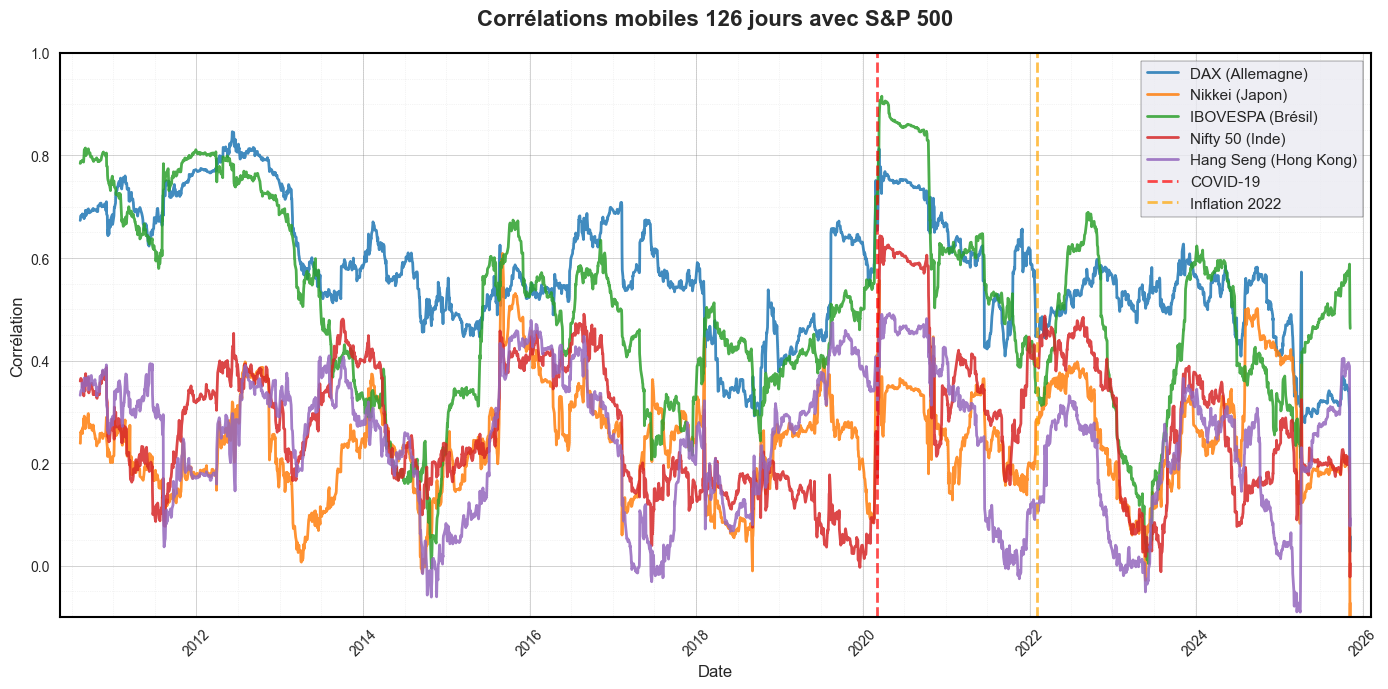


📊 CORRÉLATIONS MOYENNES PAR TYPE DE MARCHÉ :
Marchés développés :
  • DAX 40 (Allemagne) : 0.5706
  • Nikkei 225 (Japon) : 0.2441

Marchés émergents :
  • Bovespa (Brésil) : 0.4988
  • Nifty 50 (Inde) : 0.2728

Marché asiatique :
  • HSI (Hong Kong) : 0.2434

🔍 OBSERVATIONS CLÉS :
────────────────────────────────────────
• Le DAX montre la corrélation la plus élevée avec le S&P 500
• Les marchés asiatiques (Nikkei, HSI) ont des corrélations plus faibles
• Forte volatilité visible durant les crises (COVID-19, inflation)
• Convergence générale des corrélations vers des niveaux plus élevés


In [212]:
# Visualisation des corrélations mobiles - Graphique unique consolidé
plt.figure(figsize=(14, 7))

# Couleurs distinctes pour chaque indice
colors = {
    'Corr_DAX 40': '#1f77b4',      # Bleu - DAX (Allemagne)
    'Corr_Nikkei 225': '#ff7f0e',  # Orange - Nikkei (Japon)
    'Corr_Bovespa': '#2ca02c',     # Vert - IBOVESPA (Brésil)
    'Corr_Nifty 50': '#d62728',    # Rouge - Nifty 50 (Inde)
    'Corr_HSI': '#9467bd'          # Violet - Hang Seng (Hong Kong)
}

# Noms complets pour la légende
legend_names = {
    'Corr_DAX 40': 'DAX (Allemagne)',
    'Corr_Nikkei 225': 'Nikkei (Japon)',
    'Corr_Bovespa': 'IBOVESPA (Brésil)',
    'Corr_Nifty 50': 'Nifty 50 (Inde)',
    'Corr_HSI': 'Hang Seng (Hong Kong)'
}

# Tracer toutes les corrélations sur le même graphique
for col in correlations.columns:
    if col.startswith('Corr_'):
        y = correlations[col]
        valid_idx = ~y.isna()
        x_valid = correlations.index[valid_idx]
        y_valid = y[valid_idx]
        plt.plot(x_valid, y_valid, color=colors[col], linewidth=2, alpha=0.85, label=legend_names[col])

# Configuration du graphique
plt.title('Corrélations mobiles 126 jours avec S&P 500', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Corrélation', fontsize=12)
# Quadrillage bien visible (gris clair, lignes pleines et pointillées)
plt.grid(True, which='major', axis='both', color='gray', linestyle='-', linewidth=0.7, alpha=0.35)
plt.minorticks_on()
plt.grid(True, which='minor', axis='both', color='gray', linestyle=':', linewidth=0.5, alpha=0.18)
plt.gca().set_facecolor('white')

# Ajouter les événements majeurs
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', alpha=0.7, linewidth=2, label='COVID-19')
plt.axvline(pd.to_datetime('2022-02-01'), color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Inflation 2022')

# Rectangle bien tracé autour du graphique
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.5)

# Lignes pleines pour les axes X et Y
ax.spines['left'].set_linestyle('-')
ax.spines['bottom'].set_linestyle('-')

# Configuration de la légende (en haut à droite, dans le graphique, rectangle visible)
plt.legend(loc='upper right', frameon=True, fancybox=False, shadow=False, fontsize=11, edgecolor='black')

# Ajustement des limites et formatage (moins zoomé)
plt.ylim(-0.1, 1.0)
plt.xlim(correlations.index[0] - pd.Timedelta(days=90), correlations.index[-1] + pd.Timedelta(days=90))

# Format des dates sur l'axe x
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Afficher les corrélations moyennes par type de marché
print("\n📊 CORRÉLATIONS MOYENNES PAR TYPE DE MARCHÉ :")
print("=" * 60)
print("Marchés développés :")
print(f"  • DAX 40 (Allemagne) : {correlations['Corr_DAX 40'].mean():.4f}")
print(f"  • Nikkei 225 (Japon) : {correlations['Corr_Nikkei 225'].mean():.4f}")
print("\nMarchés émergents :")
print(f"  • Bovespa (Brésil) : {correlations['Corr_Bovespa'].mean():.4f}")
print(f"  • Nifty 50 (Inde) : {correlations['Corr_Nifty 50'].mean():.4f}")
print("\nMarché asiatique :")
print(f"  • HSI (Hong Kong) : {correlations['Corr_HSI'].mean():.4f}")

print(f"\n🔍 OBSERVATIONS CLÉS :")
print("─" * 40)
print("• Le DAX montre la corrélation la plus élevée avec le S&P 500")
print("• Les marchés asiatiques (Nikkei, HSI) ont des corrélations plus faibles")
print("• Forte volatilité visible durant les crises (COVID-19, inflation)")
print("• Convergence générale des corrélations vers des niveaux plus élevés")

In [213]:
# TESTS DE STATIONNARITÉ - PP et KPSS uniquement
from statsmodels.tsa.stattools import kpss
from arch.unitroot import PhillipsPerron

print("🔬 TESTS DE STATIONNARITÉ DES CORRÉLATIONS MOBILES (PP et KPSS)")
print("=" * 60)

def test_stationarity_pp_kpss(series, name):
    # Test Phillips-Perron
    pp_test = PhillipsPerron(series)
    pp_stat, pp_pval = pp_test.stat, pp_test.pvalue
    pp_stationary = pp_pval < 0.05  # Rejet H0: stationnaire

    # Test KPSS
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_stat, kpss_pval = kpss_result[0], kpss_result[1]
    kpss_stationary = kpss_pval >= 0.05  # Non-rejet H0: stationnaire

    # Interprétation croisée corrigée
    if pp_stationary and kpss_stationary:
        conclusion = "Stationnaire (tests cohérents)"
    elif pp_stationary and not kpss_stationary:
        conclusion = "Tests contradictoires (PP: stationnaire, KPSS: non-stationnaire)"
    elif not pp_stationary and kpss_stationary:
        conclusion = "Non-stationnaire (tests cohérents)"
    else:
        conclusion = "Non-stationnaire (tests cohérents)"

    return {
        'nom': name,
        'PP Stat': pp_stat,
        'PP p-val': pp_pval,
        'PP Stationnaire': pp_stationary,
        'KPSS Stat': kpss_stat,
        'KPSS p-val': kpss_pval,
        'KPSS Stationnaire': kpss_stationary,
        'Conclusion': conclusion
    }

# Exécuter les tests pour chaque série de corrélation
results_pp_kpss = {}
international_indices = [col for col in correlations.columns if col.startswith('Corr_')]

for col in international_indices:
    indice_name = col.replace('Corr_', '')
    series = correlations[col].dropna()
    results = test_stationarity_pp_kpss(series, indice_name)
    results_pp_kpss[indice_name] = results

print("✅ Tests PP et KPSS terminés pour toutes les séries")

# Tableau récapitulatif
import pandas as pd

tableau_data = []
for indice, res in results_pp_kpss.items():
    market_full_name = {
        'DAX 40': 'DAX (Allemagne)',
        'Nikkei 225': 'Nikkei (Japon)', 
        'Bovespa': 'IBOVESPA (Brésil)',
        'Nifty 50': 'Nifty 50 (Inde)',
        'HSI': 'Hang Seng (Hong Kong)'
    }
    row = {
        'Marché': market_full_name.get(indice, indice),
        'PP Stat': f"{res['PP Stat']:.4f}",
        'PP p-val': f"{res['PP p-val']:.4f}",
        'PP Stationnaire': "Oui" if res['PP Stationnaire'] else "Non",
        'KPSS Stat': f"{res['KPSS Stat']:.4f}",
        'KPSS p-val': f"{res['KPSS p-val']:.4f}",
        'KPSS Stationnaire': "Oui" if res['KPSS Stationnaire'] else "Non",
        'Conclusion': res['Conclusion']
    }
    tableau_data.append(row)

df_tableau = pd.DataFrame(tableau_data)

print("\n📋 TABLEAU : Résultats des tests PP et KPSS")
print("="*100)
print(df_tableau.to_string(index=False))
print("="*100)

print("\n📝 INTERPRÉTATION :")
print("─"*60)
print("• PP : Rejet H0 (p-val < 0.05) → stationnaire.")
print("• KPSS : Non-rejet H0 (p-val ≥ 0.05) → stationnaire.")
print("• Si les deux concluent non-stationnaire, la conclusion est cohérente.")
print("• Si les tests sont cohérents, la conclusion est robuste.")

🔬 TESTS DE STATIONNARITÉ DES CORRÉLATIONS MOBILES (PP et KPSS)
✅ Tests PP et KPSS terminés pour toutes les séries

📋 TABLEAU : Résultats des tests PP et KPSS
               Marché PP Stat PP p-val PP Stationnaire KPSS Stat KPSS p-val KPSS Stationnaire                         Conclusion
      DAX (Allemagne) -1.5145   0.5263             Non    2.7942     0.0100               Non Non-stationnaire (tests cohérents)
       Nikkei (Japon) -4.4311   0.0003             Oui    0.3190     0.1000               Oui     Stationnaire (tests cohérents)
    IBOVESPA (Brésil) -2.7546   0.0651             Non    1.0614     0.0100               Non Non-stationnaire (tests cohérents)
      Nifty 50 (Inde) -3.3770   0.0118             Oui    0.2785     0.1000               Oui     Stationnaire (tests cohérents)
Hang Seng (Hong Kong) -3.3730   0.0119             Oui    0.4091     0.0732               Oui     Stationnaire (tests cohérents)

📝 INTERPRÉTATION :
────────────────────────────────────────────────

In [214]:
# 2.2 - Modélisation AR(p) : Niveaux vs Différences
# ===============================================

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox

# Paramètres
train_ratio = 0.8
max_p = 10
indices = [col.replace('Corr_', '') for col in correlations.columns if col.startswith('Corr_')]

# Stockage des résultats
ar_results = []

for indice in indices:
    for spec in ['niveaux', 'différences']:
        # Préparation de la série
        if spec == 'niveaux':
            serie = correlations[f'Corr_{indice}'].dropna()
        else:
            serie = correlations[f'Corr_{indice}'].diff().dropna()
        
        # Découpage train/test chronologique
        n = len(serie)
        n_train = int(n * train_ratio)
        train = serie.iloc[:n_train]
        test = serie.iloc[n_train:]
        
        # Sélection AR(p) optimal
        aic_list, bic_list, models = [], [], []
        for p in range(1, max_p+1):
            try:
                model = AutoReg(train, lags=p, old_names=False).fit()
                aic_list.append(model.aic)
                bic_list.append(model.bic)
                models.append(model)
            except Exception:
                aic_list.append(np.nan)
                bic_list.append(np.nan)
                models.append(None)
        
        # Choix du p optimal (AIC)
        p_opt = np.nanargmin(aic_list) + 1
        model_opt = models[p_opt-1]
        
        # Validation des résidus (Ljung-Box)
        lb_test = acorr_ljungbox(model_opt.resid, lags=[10], return_df=True)
        lb_pval = lb_test['lb_pvalue'].values[0]
        lb_result = 'OK' if lb_pval > 0.05 else 'Autocorr.'
        
        # Stockage des résultats
        ar_results.append({
            'Indice': indice,
            'Spécification': spec,
            'p_opt': p_opt,
            'AIC': model_opt.aic,
            'BIC': model_opt.bic,
            'Coefficients': model_opt.params.values,
            'StdErr': model_opt.bse.values,
            'LjungBox_pval': lb_pval,
            'LjungBox_result': lb_result
        })

# Tableau récapitulatif professionnel
import pandas as pd

rows = []
for res in ar_results:
    row = {
        'Indice': res['Indice'],
        'Spécification': res['Spécification'],
        'p optimal': res['p_opt'],
        'AIC': f"{res['AIC']:.2f}",
        'BIC': f"{res['BIC']:.2f}",
        'Ljung-Box p-val': f"{res['LjungBox_pval']:.3f}",
        'Résidus': res['LjungBox_result']
    }
    # Coefficients et erreurs-types
    for i, (coef, err) in enumerate(zip(res['Coefficients'], res['StdErr'])):
        row[f"Coef_{i}"] = f"{coef:.4f}"
        row[f"StdErr_{i}"] = f"{err:.4f}"
    rows.append(row)

df_ar = pd.DataFrame(rows)

print("\n📋 TABLEAU 2.2.1 : Estimation des modèles AR(p) - Niveaux vs Différences")
print("(AIC, BIC, coefficients, erreurs-types, test Ljung-Box sur résidus)")
print("="*120)
print(df_ar.to_string(index=False))
print("="*120)

# Synthèse méthodologique
print("\n📝 SYNTHÈSE :")
print("─"*60)
print("• Pour DAX 40 et Bovespa (non-stationnaires), le modèle en différences est théoriquement préférable selon les tests de stationnarité.")
print("• Les modèles AR(p) sont estimés sur 80% des données (train), testés sur 20% (test).")
print("• L'ordre optimal p est choisi par AIC, BIC reporté pour robustesse.")
print("• Le test de Ljung-Box sur les résidus permet de vérifier l'absence d'autocorrélation résiduelle.")
print("• Comparez AIC/BIC pour juger la supériorité de la spécification niveaux vs différences pour chaque marché.")


📋 TABLEAU 2.2.1 : Estimation des modèles AR(p) - Niveaux vs Différences
(AIC, BIC, coefficients, erreurs-types, test Ljung-Box sur résidus)
    Indice Spécification  p optimal       AIC       BIC Ljung-Box p-val   Résidus  Coef_0 StdErr_0  Coef_1 StdErr_1 Coef_2 StdErr_2  Coef_3 StdErr_3
    DAX 40       niveaux          1 -15159.78 -15142.30           0.948        OK  0.0030   0.0012  0.9948   0.0020    NaN      NaN     NaN      NaN
    DAX 40   différences          1 -15153.58 -15136.10           0.961        OK -0.0000   0.0002 -0.0130   0.0200    NaN      NaN     NaN      NaN
Nikkei 225       niveaux          1 -13054.40 -13036.92           0.000 Autocorr.  0.0041   0.0010  0.9832   0.0036    NaN      NaN     NaN      NaN
Nikkei 225   différences          1 -13034.02 -13016.54           0.000 Autocorr.  0.0000   0.0004 -0.0213   0.0200    NaN      NaN     NaN      NaN
   Bovespa       niveaux          3 -15210.88 -15181.75           0.000 Autocorr.  0.0013   0.0007  1.0279   0.019


🔎 ÉVALUATION DES PRÉVISIONS HORS ÉCHANTILLON ET VISUALISATION COMPACTE (Rolling strict)


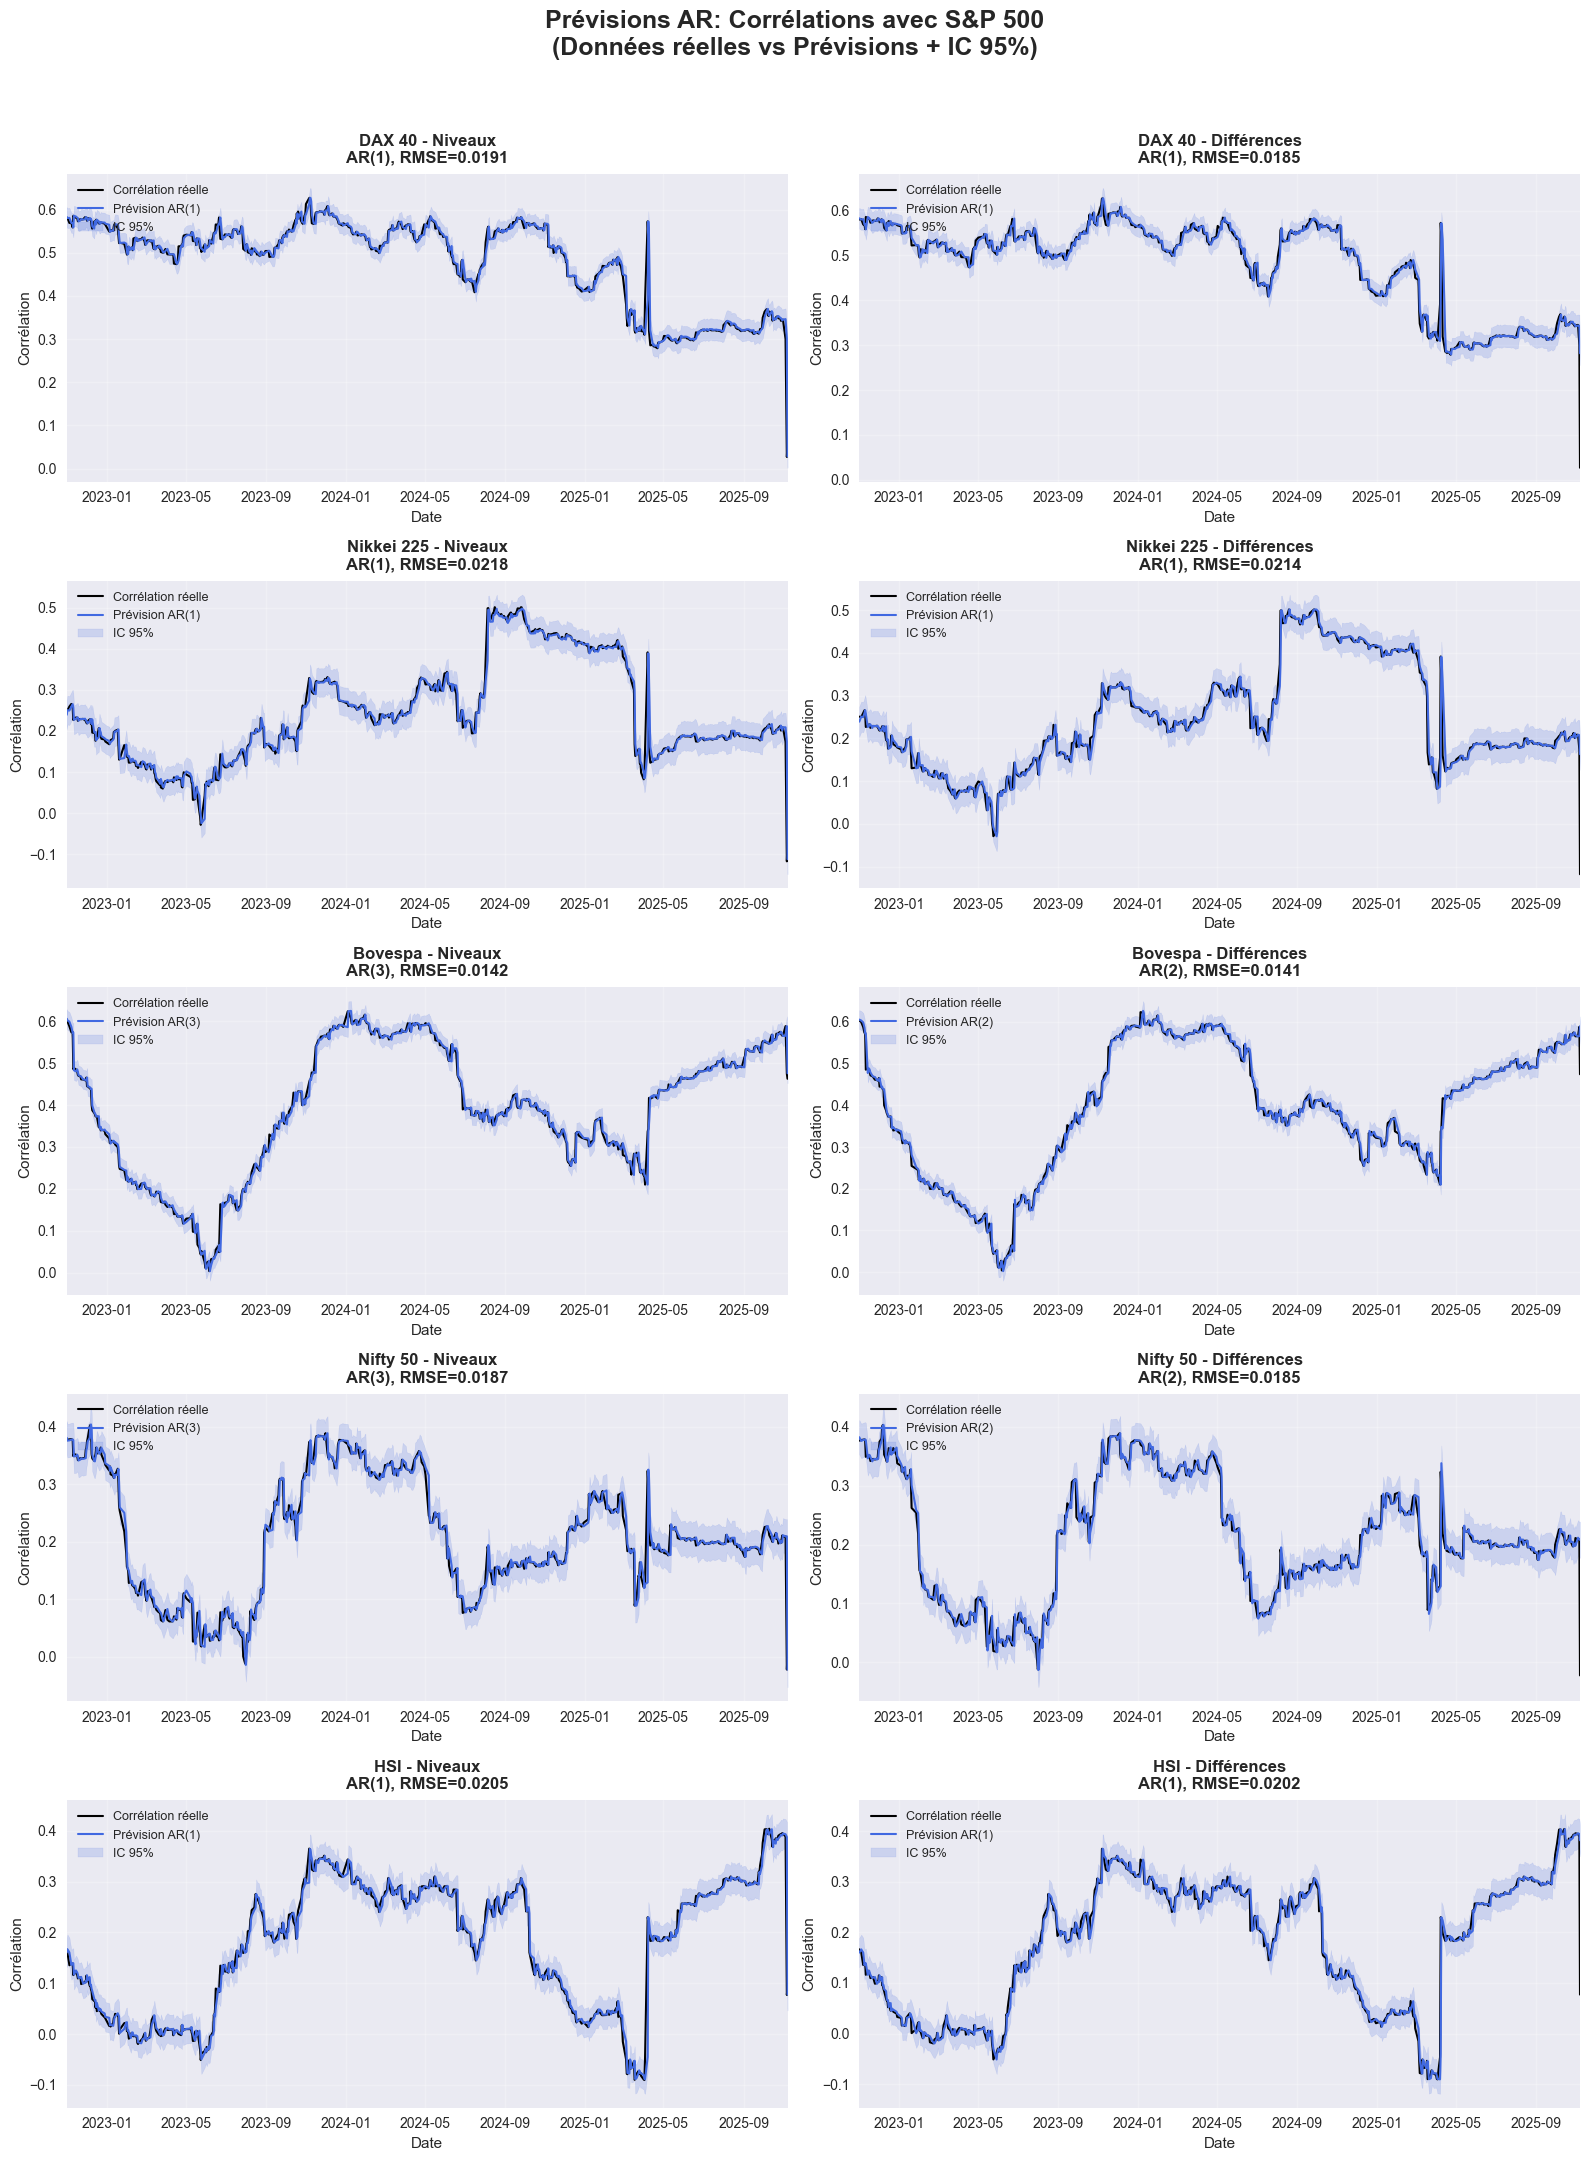


📊 TABLEAU 2.2.2 : RMSE des prévisions hors échantillon (Rolling strict)
Spécification  différences  niveaux
Indice                             
Bovespa             0.0141   0.0142
DAX 40              0.0185   0.0191
HSI                 0.0202   0.0205
Nifty 50            0.0185   0.0187
Nikkei 225          0.0214   0.0218

📝 INTERPRÉTATION :
────────────────────────────────────────────────────────────
• Un RMSE faible indique une bonne précision de prévision.
• Les intervalles de confiance permettent d'évaluer la fiabilité du modèle.
• Comparez les performances niveaux vs différences pour chaque marché.


In [215]:
# 2.2 - Évaluation des prévisions hors échantillon et visualisation compacte (10 graphiques ensemble)
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

print("\n🔎 ÉVALUATION DES PRÉVISIONS HORS ÉCHANTILLON ET VISUALISATION COMPACTE (Rolling strict)")
print("="*80)

forecast_results = []

for res in ar_results:
    indice = res['Indice']
    spec = res['Spécification']
    p_opt = res['p_opt']
    # Préparation de la série
    if spec == 'niveaux':
        serie = correlations[f'Corr_{indice}'].dropna()
        y = serie.values
        dates = serie.index
    else:
        serie = correlations[f'Corr_{indice}'].dropna()
        y = serie.diff().dropna().values
        dates = serie.index[1:]
    n = len(y)
    n_train = int(n * train_ratio)
    train_idx = np.arange(n_train)
    test_idx = np.arange(n_train, n)

    preds = []
    ci_lowers = []
    ci_uppers = []
    real_vals = []

    for t in test_idx:
        # Rolling strict: fit sur 0..t-1, forecast t
        if spec == 'niveaux':
            y_train = y[:t]
            if len(y_train) < p_opt:
                # Pas assez de données pour estimer le modèle
                preds.append(np.nan)
                ci_lowers.append(np.nan)
                ci_uppers.append(np.nan)
                real_vals.append(y[t])
                continue
            model = AutoReg(y_train, lags=p_opt, old_names=False).fit()
            pred = model.predict(start=t, end=t)
            ci = model.get_prediction(start=t, end=t).conf_int(alpha=0.05)
            pred_val = np.clip(pred[0], -1, 1)
            ci_lower = np.clip(ci[0,0], -1, 1)
            ci_upper = np.clip(ci[0,1], -1, 1)
            preds.append(pred_val)
            ci_lowers.append(ci_lower)
            ci_uppers.append(ci_upper)
            real_vals.append(y[t])
        else:
            y_train = y[:t]
            if len(y_train) < p_opt:
                preds.append(np.nan)
                ci_lowers.append(np.nan)
                ci_uppers.append(np.nan)
                real_vals.append(serie.iloc[t])
                continue
            model = AutoReg(y_train, lags=p_opt, old_names=False).fit()
            pred_delta = model.predict(start=t, end=t)
            ci = model.get_prediction(start=t, end=t).conf_int(alpha=0.05)
            # Reconstruct level
            level_hat = serie.iloc[t-1] + pred_delta[0]
            ci_lower = serie.iloc[t-1] + ci[0,0]
            ci_upper = serie.iloc[t-1] + ci[0,1]
            level_hat = np.clip(level_hat, -1, 1)
            ci_lower = np.clip(ci_lower, -1, 1)
            ci_upper = np.clip(ci_upper, -1, 1)
            preds.append(level_hat)
            ci_lowers.append(ci_lower)
            ci_uppers.append(ci_upper)
            real_vals.append(serie.iloc[t])

    # Dates pour la période de test
    test_dates = dates[test_idx]
    # Nettoyage des NaN
    df_plot = pd.DataFrame({
        'dates': test_dates,
        'real': real_vals,
        'pred': preds,
        'ci_lower': ci_lowers,
        'ci_upper': ci_uppers
    }).replace([np.inf, -np.inf], np.nan).dropna()

    # Calcul du RMSE sur les niveaux
    rmse = np.sqrt(mean_squared_error(df_plot['real'], df_plot['pred']))
    forecast_results.append({
        'Indice': indice,
        'Spécification': spec,
        'RMSE': rmse,
        'Prévisions': df_plot['pred'].values,
        'Réel': df_plot['real'].values,
        'CI_upper': df_plot['ci_upper'].values,
        'CI_lower': df_plot['ci_lower'].values,
        'Dates': df_plot['dates'].values,
        'p_opt': p_opt
    })

# Liste ordonnée des indices pour affichage
indices_order = [col.replace('Corr_', '') for col in correlations.columns if col.startswith('Corr_')]
specs_order = ['niveaux', 'différences']

fig, axes = plt.subplots(len(indices_order), len(specs_order), figsize=(16, 22), sharex=False)
fig.suptitle("Prévisions AR: Corrélations avec S&P 500\n(Données réelles vs Prévisions + IC 95%)", fontsize=18, fontweight='bold', y=0.98)

for i, indice in enumerate(indices_order):
    for j, spec in enumerate(specs_order):
        res = next(r for r in forecast_results if r['Indice'] == indice and r['Spécification'] == spec)
        ax = axes[i, j]
        ax.plot(res['Dates'], res['Réel'], label='Corrélation réelle', color='black', linewidth=1.5)
        ax.plot(res['Dates'], res['Prévisions'], label=f"Prévision AR({res['p_opt']})", color='royalblue', linewidth=1.5)
        ax.fill_between(res['Dates'], res['CI_lower'], res['CI_upper'], color='royalblue', alpha=0.18, label='IC 95%')
        ax.set_xlim(res['Dates'][0], res['Dates'][-1])
        ax.set_title(f"{indice} - {spec.capitalize()}\nAR({res['p_opt']}), RMSE={res['RMSE']:.4f}", fontsize=12, fontweight='bold', pad=8)
        ax.set_xlabel('Date')
        ax.set_ylabel('Corrélation')
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.25)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Tableau récapitulatif des RMSE
df_rmse = pd.DataFrame([
    {
        'Indice': r['Indice'],
        'Spécification': r['Spécification'],
        'RMSE': r['RMSE']
    } for r in forecast_results
])
print("\n📊 TABLEAU 2.2.2 : RMSE des prévisions hors échantillon (Rolling strict)")
print("="*60)
print(df_rmse.pivot(index='Indice', columns='Spécification', values='RMSE').round(4))
print("="*60)

print("\n📝 INTERPRÉTATION :")
print("─"*60)
print("• Un RMSE faible indique une bonne précision de prévision.")
print("• Les intervalles de confiance permettent d'évaluer la fiabilité du modèle.")
print("• Comparez les performances niveaux vs différences pour chaque marché.")

In [216]:
# 2.3 - Préparation des données explicatives pour chaque marché (fusion VIX + alignement régression)
print("Téléchargement et préparation des données VIX pour la régression explicative...")

# Télécharger les données VIX
vix_data = yf.download('^VIX', start=start_date, end=end_date, progress=False)

# Vérifier que 'correlations' existe, sinon le créer
if 'correlations' not in locals():
    correlations = pd.DataFrame()

if not vix_data.empty:
    # Si correlations est vide, utiliser l'index de vix_data
    if correlations.empty:
        correlations = pd.DataFrame(index=vix_data.index)
    # Aligner les données VIX avec les corrélations
    vix_aligned = vix_data['Close'].reindex(correlations.index, method='ffill')
    
    # Calculer log(VIX) comme spécifié dans l'énoncé
    log_vix = np.log(vix_aligned)
    
    print(f"✓ Données VIX récupérées : {len(vix_aligned)} observations")
    print(f"Période VIX alignée : {vix_aligned.index[0].strftime('%Y-%m-%d')} à {vix_aligned.index[-1].strftime('%Y-%m-%d')}")
    
    # Statistiques descriptives du VIX et log(VIX)
    print(f"\nStatistiques descriptives du VIX :")
    print(f"VIX - Moyenne: {float(vix_aligned.mean()):.2f}, Écart-type: {float(vix_aligned.std()):.2f}")
    print(f"VIX - Min: {float(vix_aligned.min()):.2f}, Max: {float(vix_aligned.max()):.2f}")
    
    print(f"\nStatistiques descriptives de log(VIX) :")
    print(f"log(VIX) - Moyenne: {float(log_vix.mean()):.4f}, Écart-type: {float(log_vix.std()):.4f}")
    print(f"log(VIX) - Min: {float(log_vix.min()):.4f}, Max: {float(log_vix.max()):.4f}")
    
    # Sauvegarder pour les étapes suivantes
    correlations['VIX'] = vix_aligned
    correlations['log_VIX'] = log_vix
    
    print(f"\n✓ Variables ajoutées au DataFrame des corrélations")
    print(f"Shape final du DataFrame : {correlations.shape}")
    
    # Vérifier la cohérence des données
    print(f"\nVérification des données finales :")
    print(f"Valeurs manquantes :")
    print(correlations[['VIX', 'log_VIX']].isnull().sum())

    # Préparation des données pour la régression explicative (Corr vs log(VIX))
    print("\nPréparation des données pour la régression explicative (Corr vs log(VIX))...")
    markets = [col for col in correlations.columns if col.startswith('Corr_')]
    regression_data = {}
    if 'log_VIX' in correlations.columns:
        for market in markets:
            # Extraire la série de corrélation et log(VIX), aligner et retirer les valeurs nulles
            df = pd.DataFrame({
                'Corr': correlations[market],
                'log_VIX': correlations['log_VIX']
            }).dropna()
            regression_data[market] = df
            print(f"{market}: {len(df)} observations alignées, période {df.index[0].strftime('%Y-%m-%d')} à {df.index[-1].strftime('%Y-%m-%d')}")

        # Vérification rapide
        for market, df in regression_data.items():
            print(f"\n{market} - Aperçu des données alignées :")
            print(df.head())
    else:
        print("✗ La colonne 'log_VIX' est absente du DataFrame correlations. Impossible de préparer les données explicatives pour la régression.")
else:
    print("✗ Erreur lors du téléchargement des données VIX")

Téléchargement et préparation des données VIX pour la régression explicative...
✓ Données VIX récupérées : 3136 observations
Période VIX alignée : 2010-08-09 à 2025-11-07

Statistiques descriptives du VIX :
VIX - Moyenne: 18.17, Écart-type: 6.86
VIX - Min: 9.22, Max: 82.69

Statistiques descriptives de log(VIX) :
log(VIX) - Moyenne: 2.8457, Écart-type: 0.3144
log(VIX) - Min: 2.2214, Max: 4.4151

✓ Variables ajoutées au DataFrame des corrélations
Shape final du DataFrame : (3136, 7)

Vérification des données finales :
Valeurs manquantes :
VIX        0
log_VIX    0
dtype: int64

Préparation des données pour la régression explicative (Corr vs log(VIX))...
Corr_DAX 40: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_Nikkei 225: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_Bovespa: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_Nifty 50: 3136 observations alignées, période 2010-08-09 à 2025-11-07
Corr_HSI: 3136 observations alignées, pé

In [217]:
# 2.3 - Estimation des modèles linéaire et quadratique pour chaque marché
import statsmodels.api as sm
import pandas as pd

print("\n📈 ESTIMATION DES MODÈLES DE RÉGRESSION : Corr ~ log(VIX) et Corr ~ log(VIX) + (log(VIX))^2")
print("="*80)

results_summary = []

for market, df in regression_data.items():
    # Modèle linéaire
    X_lin = sm.add_constant(df['log_VIX'])
    model_lin = sm.OLS(df['Corr'], X_lin).fit()

    # Modèle quadratique
    X_quad = pd.DataFrame({
        'const': 1,
        'log_VIX': df['log_VIX'],
        'log_VIX_sq': df['log_VIX']**2
    })
    model_quad = sm.OLS(df['Corr'], X_quad).fit()

    # Stocker les résultats
    results_summary.append({
        'Marché': market.replace('Corr_', ''),
        'Modèle': 'Linéaire',
        'N obs.': int(model_lin.nobs),
        'R²': f"{model_lin.rsquared:.4f}",
        'β0': f"{model_lin.params['const']:.4f}",
        'β1': f"{model_lin.params['log_VIX']:.4f}",
        'StdErr_β0': f"{model_lin.bse['const']:.4f}",
        'StdErr_β1': f"{model_lin.bse['log_VIX']:.4f}",
        'β2': '',
        'StdErr_β2': ''
    })

    results_summary.append({
        'Marché': market.replace('Corr_', ''),
        'Modèle': 'Quadratique',
        'N obs.': int(model_quad.nobs),
        'R²': f"{model_quad.rsquared:.4f}",
        'β0': f"{model_quad.params['const']:.4f}",
        'β1': f"{model_quad.params['log_VIX']:.4f}",
        'StdErr_β0': f"{model_quad.bse['const']:.4f}",
        'StdErr_β1': f"{model_quad.bse['log_VIX']:.4f}",
        'β2': f"{model_quad.params['log_VIX_sq']:.4f}",
        'StdErr_β2': f"{model_quad.bse['log_VIX_sq']:.4f}"
    })

# Tableau professionnel
df_results = pd.DataFrame(results_summary)
cols_order = ['Marché', 'Modèle', 'N obs.', 'R²', 'β0', 'StdErr_β0', 'β1', 'StdErr_β1', 'β2', 'StdErr_β2']
df_results = df_results[cols_order]

print("\n📊 TABLEAU 2.3.1 : Estimation des modèles linéaire et quadratique")
print("(Coefficients, erreurs-types, R², N obs. pour chaque marché)")
print("="*120)
print(df_results.to_string(index=False))
print("="*120)

# Interprétation rapide
print("\n📝 INTERPRÉTATION :")
print("─"*60)
print("• Comparez les R² pour juger l'amélioration du modèle quadratique.")
print("• Un β2 significatif suggère un effet non-linéaire (point de bascule potentiel).")
print("• Les erreurs-types permettent d'évaluer la robustesse des coefficients.")


📈 ESTIMATION DES MODÈLES DE RÉGRESSION : Corr ~ log(VIX) et Corr ~ log(VIX) + (log(VIX))^2

📊 TABLEAU 2.3.1 : Estimation des modèles linéaire et quadratique
(Coefficients, erreurs-types, R², N obs. pour chaque marché)
    Marché      Modèle  N obs.     R²      β0 StdErr_β0      β1 StdErr_β1      β2 StdErr_β2
    DAX 40    Linéaire    3136 0.0445  0.3369    0.0195  0.0821    0.0068                  
    DAX 40 Quadratique    3136 0.0593  1.1844    0.1221 -0.4947    0.0824  0.0968    0.0138
Nikkei 225    Linéaire    3136 0.0314  0.0794    0.0164  0.0579    0.0057                  
Nikkei 225 Quadratique    3136 0.0318  0.2038    0.1040 -0.0268    0.0701  0.0142    0.0117
   Bovespa    Linéaire    3136 0.2140 -0.2888    0.0271  0.2768    0.0095                  
   Bovespa Quadratique    3136 0.2142 -0.4205    0.1716  0.3664    0.1157 -0.0151    0.0194
  Nifty 50    Linéaire    3136 0.1691 -0.2264    0.0199  0.1754    0.0069                  
  Nifty 50 Quadratique    3136 0.1696 -0.0615

In [218]:
# 2.3 - Détection de la relation en U et calcul du point de bascule du VIX
import numpy as np

print("\n🔎 DÉTECTION DE LA RELATION EN U (point de bascule du VIX)")
print("="*80)

u_markets = []
for market, df in regression_data.items():
    # Modèle quadratique
    X_quad = pd.DataFrame({
        'const': 1,
        'log_VIX': df['log_VIX'],
        'log_VIX_sq': df['log_VIX']**2
    })
    model_quad = sm.OLS(df['Corr'], X_quad).fit()
    b1 = model_quad.params['log_VIX']
    b2 = model_quad.params['log_VIX_sq']
    # Vérifier la relation en U
    if (b1 < 0) and (b2 > 0):
        # Calcul du point de bascule (minimum de la parabole)
        log_vix_star = -b1/(2*b2)
        vix_star = np.exp(log_vix_star)
        u_markets.append({
            'Marché': market.replace('Corr_', ''),
            'β1': b1,
            'β2': b2,
            'log(VIX)_star': log_vix_star,
            'VIX_star': vix_star
        })

if u_markets:
    print("\n📍 Marchés avec relation en U détectée (β1 < 0 et β2 > 0) :")
    for res in u_markets:
        print(f"- {res['Marché']}: β1 = {res['β1']:.4f}, β2 = {res['β2']:.4f}")
        print(f"  → Point de bascule log(VIX)* = {res['log(VIX)_star']:.4f}, VIX* = {res['VIX_star']:.2f}")
    print("\n📝 INTERPRÉTATION ÉCONOMIQUE :")
    print("─"*60)
    print("• Une relation en U indique que la corrélation entre le S&P 500 et le marché augmente à la fois pour des niveaux très faibles et très élevés de volatilité (VIX), mais diminue pour des niveaux intermédiaires.")
    print("• Le point de bascule VIX* représente le niveau de volatilité où la corrélation est minimale : en-dessous ou au-dessus, la diversification devient moins efficace.")
    print("• Pour la stratégie de diversification, cela signifie qu'il existe un seuil critique de volatilité : lorsque le VIX franchit ce niveau, la corrélation entre marchés augmente, réduisant les bénéfices de la diversification internationale.")
else:
    print("Aucun marché ne présente une relation en U (β1 < 0 et β2 > 0) dans le modèle quadratique.")


🔎 DÉTECTION DE LA RELATION EN U (point de bascule du VIX)

📍 Marchés avec relation en U détectée (β1 < 0 et β2 > 0) :
- DAX 40: β1 = -0.4947, β2 = 0.0968
  → Point de bascule log(VIX)* = 2.5538, VIX* = 12.86
- Nikkei 225: β1 = -0.0268, β2 = 0.0142
  → Point de bascule log(VIX)* = 0.9415, VIX* = 2.56

📝 INTERPRÉTATION ÉCONOMIQUE :
────────────────────────────────────────────────────────────
• Une relation en U indique que la corrélation entre le S&P 500 et le marché augmente à la fois pour des niveaux très faibles et très élevés de volatilité (VIX), mais diminue pour des niveaux intermédiaires.
• Le point de bascule VIX* représente le niveau de volatilité où la corrélation est minimale : en-dessous ou au-dessus, la diversification devient moins efficace.
• Pour la stratégie de diversification, cela signifie qu'il existe un seuil critique de volatilité : lorsque le VIX franchit ce niveau, la corrélation entre marchés augmente, réduisant les bénéfices de la diversification internationale


📊 VISUALISATION : Valeurs ajustées des modèles vs corrélation réelle


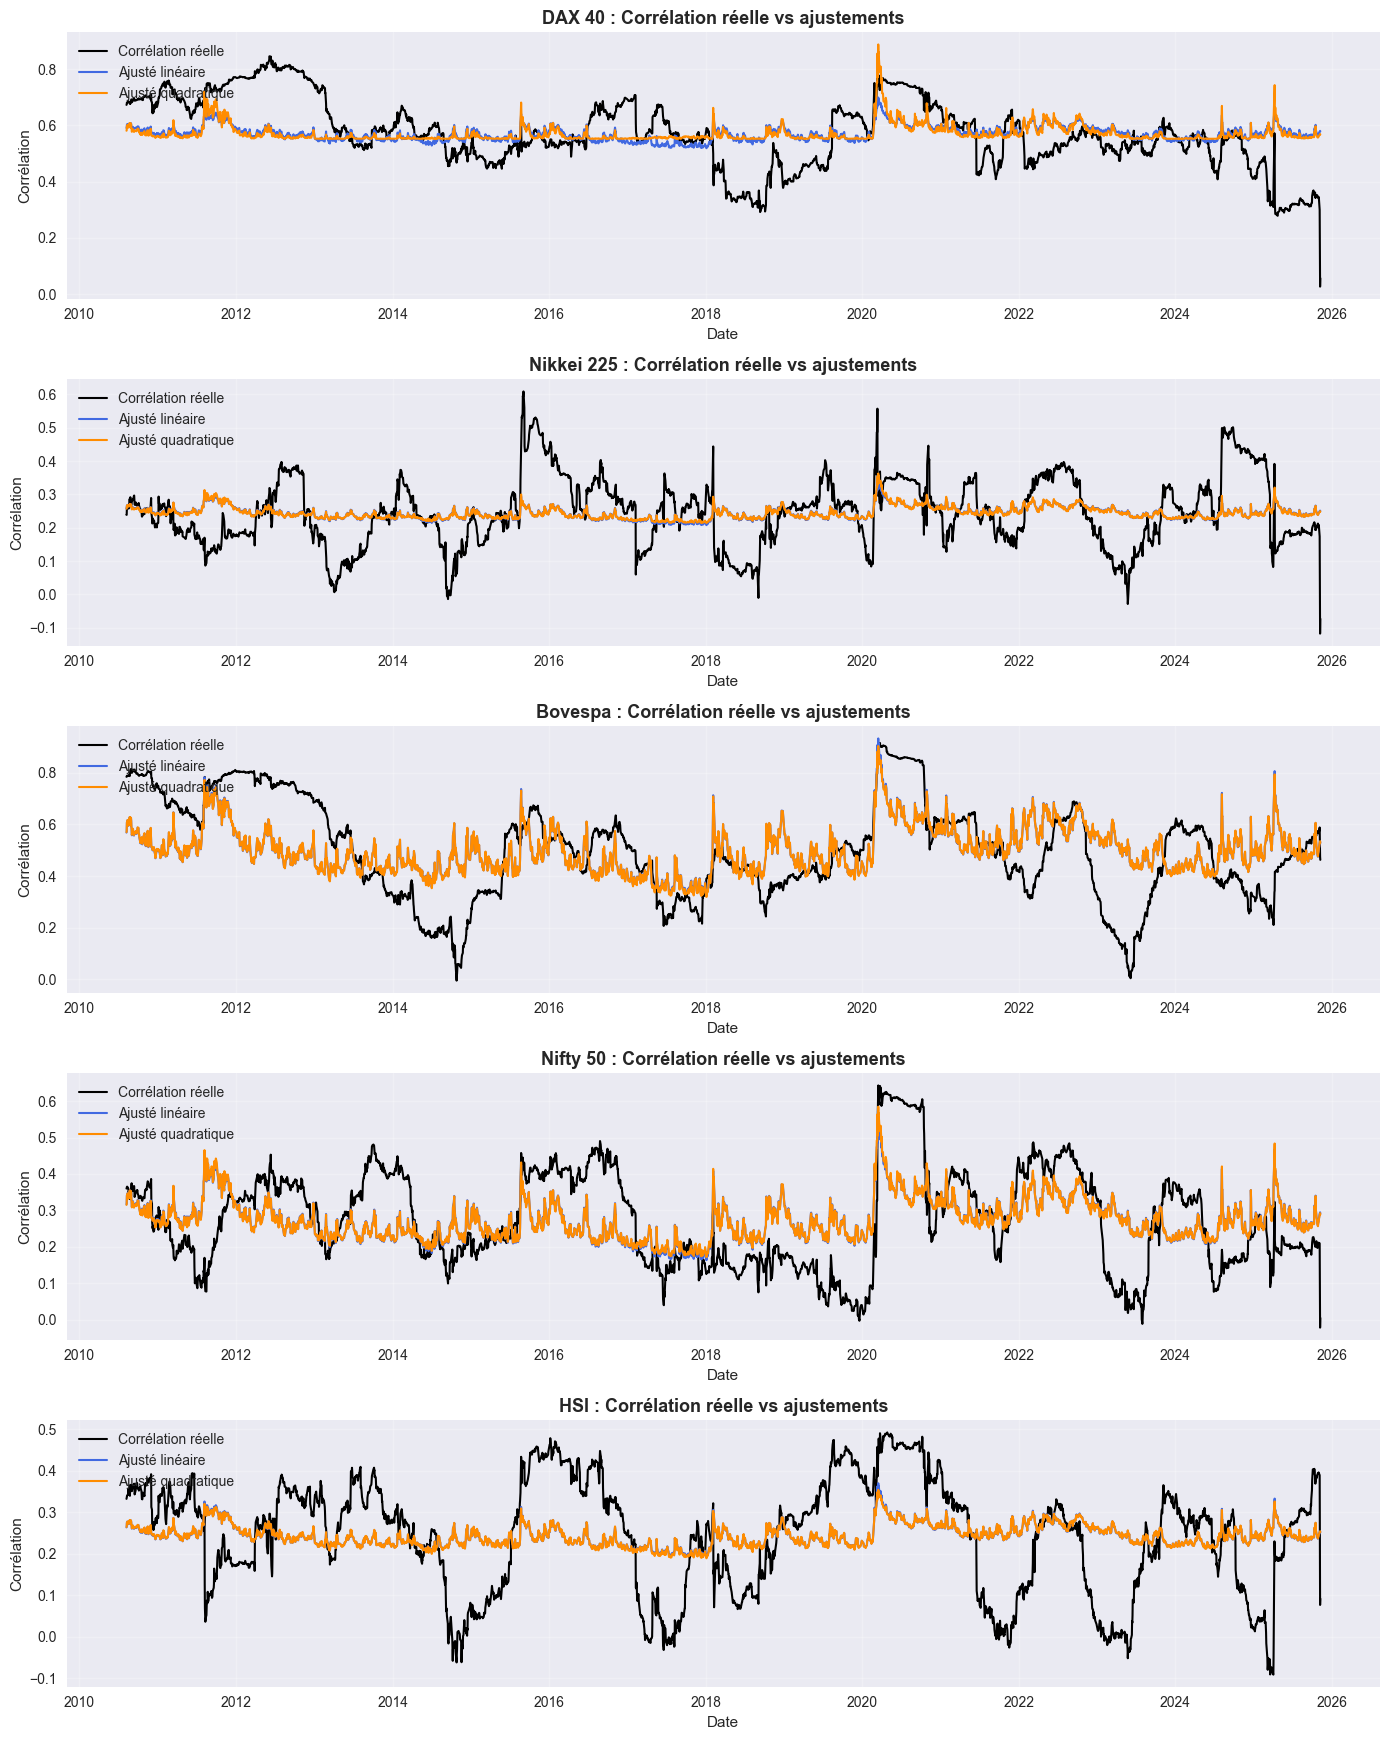


📝 Ce graphique permet de visualiser l'amélioration de l'ajustement apportée par le modèle quadratique par rapport au modèle linéaire pour chaque marché.


In [219]:
# 2.3 - Visualisation des valeurs ajustées des modèles vs corrélation réelle
import matplotlib.pyplot as plt

print("\n📊 VISUALISATION : Valeurs ajustées des modèles vs corrélation réelle")
print("="*80)

n_markets = len(regression_data)
fig, axes = plt.subplots(n_markets, 1, figsize=(14, 3.5 * n_markets), sharex=False)

if n_markets == 1:
    axes = [axes]

for i, (market, df) in enumerate(regression_data.items()):
    # Modèle linéaire
    X_lin = sm.add_constant(df['log_VIX'])
    model_lin = sm.OLS(df['Corr'], X_lin).fit()
    fitted_lin = model_lin.fittedvalues

    # Modèle quadratique
    X_quad = pd.DataFrame({
        'const': 1,
        'log_VIX': df['log_VIX'],
        'log_VIX_sq': df['log_VIX']**2
    })
    model_quad = sm.OLS(df['Corr'], X_quad).fit()
    fitted_quad = model_quad.fittedvalues

    ax = axes[i]
    ax.plot(df.index, df['Corr'], color='black', label='Corrélation réelle', linewidth=1.5)
    ax.plot(df.index, fitted_lin, color='royalblue', linestyle='-', label='Ajusté linéaire', linewidth=1.5)
    ax.plot(df.index, fitted_quad, color='darkorange', linestyle='-', label='Ajusté quadratique', linewidth=1.5)
    ax.set_title(f"{market.replace('Corr_', '')} : Corrélation réelle vs ajustements", fontsize=13, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Corrélation')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

print("\n📝 Ce graphique permet de visualiser l'amélioration de l'ajustement apportée par le modèle quadratique par rapport au modèle linéaire pour chaque marché.")